# Image enhancement-gamma transformation

## Import Lib

In [ ]:
from PIL import Image
import numpy as np
from IPython.display import display
from pynq import Xlnk
from pynq import Overlay
#import matplotlib.pyplot as plt
import cv2

## Create dma and gamma IP

In [2]:
gamma_cvt = Overlay("gamma.bit")

In [3]:
dma = gamma_cvt.axi_dma_0
gamma = gamma_cvt.gamma_transform_0

## Read Image

In [4]:
img = Image.open("1.jpg")

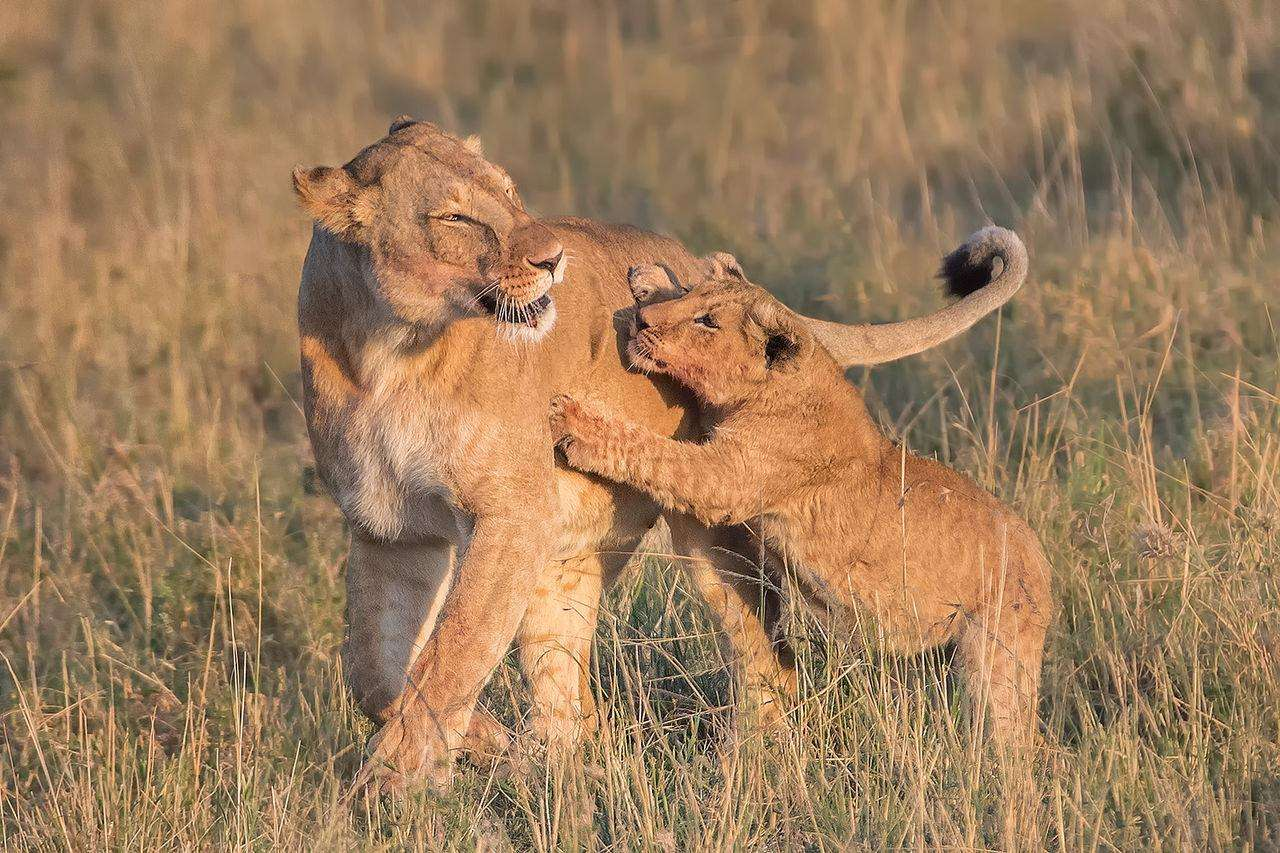

In [40]:
display(img)

In [6]:
pic_width, pic_height = img.size

In [7]:
input_array = np.array(img)

## DMA sending and receiving preparation

In [9]:
xlnk = Xlnk()

In [10]:
in_buffer = xlnk.cma_array(shape = (pic_height, pic_width, 3), dtype = np.uint8)
#in_buffer = xlnk.cma_array(shape = pic_height * pic_width * 3, dtype = np.uint8)
out_buffer = xlnk.cma_array(shape = (pic_height, pic_width, 3), dtype = np.uint8)

In [11]:
np.copyto(in_buffer, input_array)

| register offset |  configuration|
|-----------------|---------------|
| 0x14         |  number of rows for original picture       |
| 0x1c         |  number of cols for original picture       |
| 0x24         |  the parameter of c * 256 in gamma, 256 == 1.0|
| 0x2c         |  the parameter of gamma * 256 in gamma, 256 == 1.0|
| 0x34         |  mode, not use    |

In [46]:
gamma.write(0x14, pic_height)
gamma.write(0x1c, pic_width)
gamma.write(0x24, 256)
gamma.write(0x2c, 6000)
gamma.write(0x34, 1)

In [47]:
gamma.write(0x00, 0x81)
dma.sendchannel.transfer(in_buffer)
dma.recvchannel.transfer(out_buffer)


In [48]:
dma.sendchannel.wait()
dma.recvchannel.wait()

## The received picture is too large to be directly transferred to the array, so save it locally before reading and displaying

In [49]:
arr = cv2.merge([out_buffer[:,:,2], out_buffer[:,:,1], out_buffer[:,:,0]])
cv2.imwrite('cvt.jpg',arr)

True

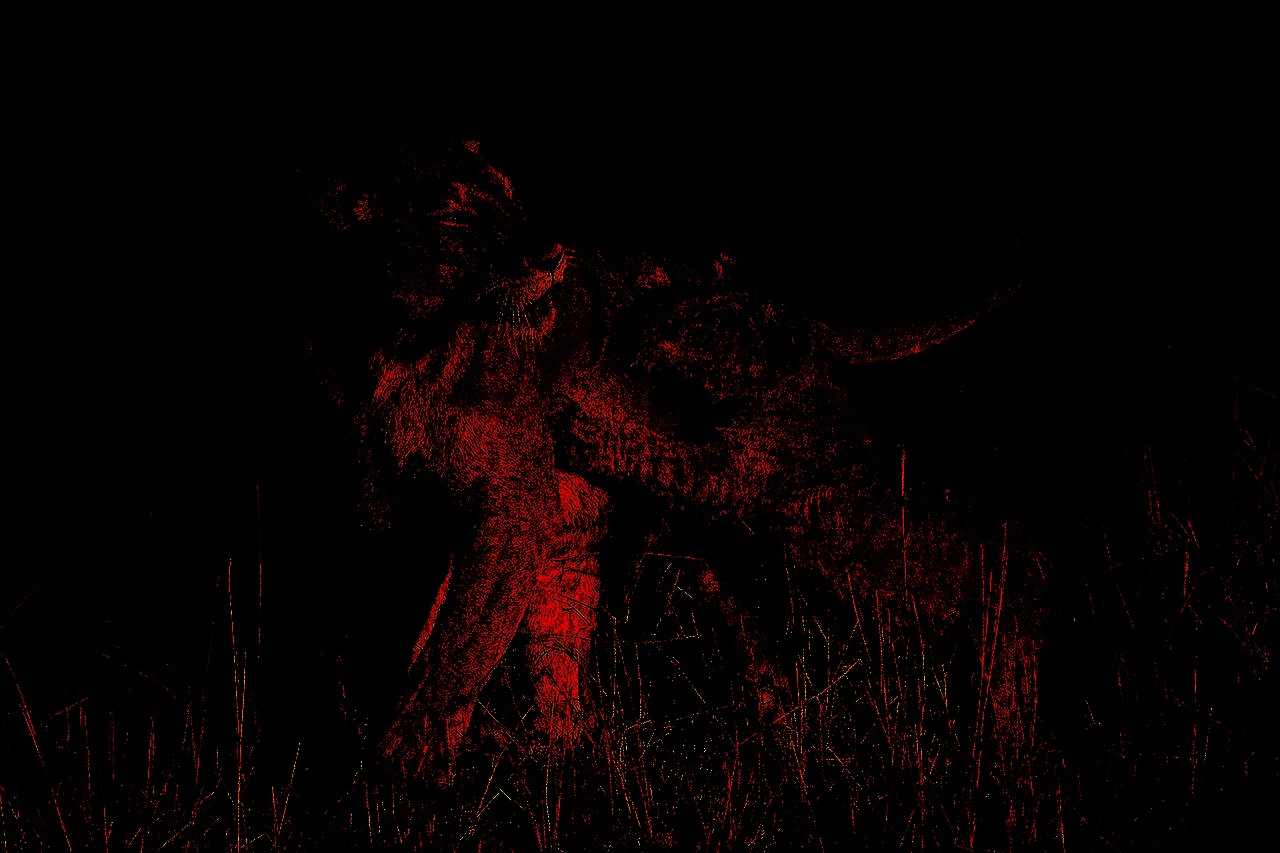

In [50]:
# cvt_img = cv2.imread('cvt.jpg', cv2.IMREAD_COLOR)
# cv2.imshow('123', cvt_img)
cvt_img = Image.open("cvt.jpg")
display(cvt_img)

In [ ]:
xlnk.xlnk_reset()